# Data Science project

This project explores the MineCraft server and player data collected by the Frank Woods reseach group in Computer Science at UBC to explore if certain player charachteristics are predictive of a newsletter subscription. 

https://plai.cs.ubc.ca/
https://www.cs.ubc.ca/~fwood/



# Question: Is there a relationship between hours played and age that predicts wheather a player has a newsletter subscription?



In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

# Variable Exploration

The first steps is to read the data, explore each variable, clean it and mutate the response variable into a factor to tell R that this is a classification problem.

In [2]:
player_data <- read_csv("data/players.csv") |>
    mutate(subscribe = as_factor(subscribe))
player_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [3]:
player_data |>
 summarise(
    mean_played = mean(played_hours, na.rm = TRUE),
    range_played = max(played_hours, na.rm = TRUE) - min(played_hours, na.rm = TRUE),
    sd_played = sd(played_hours, na.rm = TRUE),
    
    mean_age = mean(Age, na.rm = TRUE),
    range_age = max(Age, na.rm = TRUE) - min(Age, na.rm = TRUE),
    sd_age = sd(Age, na.rm = TRUE)
  )   

player_data |>
    count(experience)

player_data |>
    count(gender) |>
    print(n = Inf)

table(player_data$subscribe)

mean_played,range_played,sd_played,mean_age,range_age,sd_age
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5.845918,223.1,28.35734,20.52062,42,6.174667


experience,n
<chr>,<int>
Amateur,63
Beginner,35
Pro,14
Regular,36
Veteran,48


# A tibble: 7 × 2
  gender                n
  <chr>             <int>
1 Agender               2
2 Female               37
3 Male                124
4 Non-binary           15
5 Other                 1
6 Prefer not to say    11
7 Two-Spirited          6



FALSE  TRUE 
   52   144 

# Variables in the `player.csv` data set: 

- experience: a skill ranking - beginner(35), amature(63), regular(36), pro(14) and veteran(48)

- subscribe: whether an individual is subscribed or not to the newsletter
    - TRUE: subscribed(144)
    - FALSE: unsubscribed(52)

- hashedEmail: encrypted email address

- played_hours: total played hours
    - range: 5.8h
    - mean: 223.1h
    - standard deviation: 28.3

- name: first name

- gender: individuals gender list

    - 1 Agender(2)              
    - Female(37)               
    - Male(124)                 
    - Non-binary(15)            
    - Other(1)                  
    - Prefer not to say(11)     
    - Two-Spirited(6)          

- Age: age in years 
    - range: 42 y/o
    - mean: 20.5 y/o
    - standard deviation: 6.1 y/o

Now, we select the variables we are using as our predictors (`Age` and `played_hours`) and our outcome variable (`subscribe`)

In [4]:
select_player_data <- player_data |> 
    select(subscribe, Age, played_hours)
select_player_data

summary(select_player_data)

subscribe,Age,played_hours
<fct>,<dbl>,<dbl>
TRUE,9,30.3
TRUE,17,3.8
FALSE,17,0.0
⋮,⋮,⋮
FALSE,17,0.0
FALSE,17,2.3
TRUE,NA,0.2


 subscribe        Age         played_hours    
 FALSE: 52   Min.   : 8.00   Min.   :  0.000  
 TRUE :144   1st Qu.:17.00   1st Qu.:  0.000  
             Median :19.00   Median :  0.100  
             Mean   :20.52   Mean   :  5.846  
             3rd Qu.:22.00   3rd Qu.:  0.600  
             Max.   :50.00   Max.   :223.100  
             NA's   :2                        

Let's visualize the data on a scatter plot to see if there's an obvious relationship between age and hours played on subscription.

We also need to consider that the proportion of players with a subscription (144) VS those without (52) is very unequal - this may become a problem when training our model for classification.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


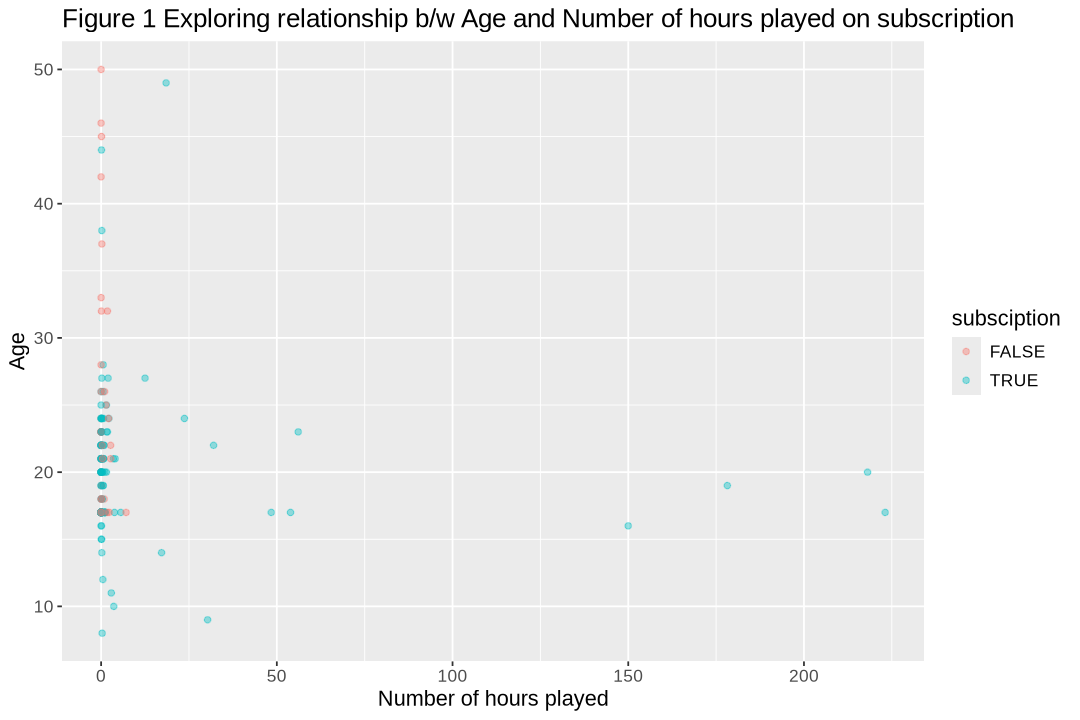

In [5]:
options(repr.plot.height = 6, repr.plot.width = 9)

player_data_plot <- select_player_data |>
    ggplot(aes(x = played_hours, y = Age, color = subscribe)) +
    geom_point(alpha = 0.4) +
    labs(x = "Number of hours played", 
         y = "Age", 
         title = "Figure 1 Exploring relationship b/w Age and Number of hours played on subscription",
        color = "subsciption") +  
    theme(text = element_text(size = 13))
player_data_plot 

From Figure 1. we can clearly see that all individuals with a high number of hours played (roughly 25h+)have newsletter subscriptions. However, individuals with 0 hours vary in subscriptions which might make it hard for our classifier to predict the class due to the ambiguity. 


Deciding on a method

knn classification - qualitative predictions and makes no assumption about the shape of the data, perfect for this data because its plotted in a non-linear shape

linear regression - quantitative predictions and only works well for data with a linear relationship

# Data Analysis
To determine if there's a relationship between hours played and age that predicts whether a player has a subscription, I approached this question as a knn classification problem because the response variable is binary and we are trying to determine the boundary that splits data points into classes.



Limitation of knn classification: 
- sensitive to class imbalance
- sensitive to unscaled ranges; must scale predictors
- can be over or underfit based off K value
- hard to interpret

Split data 

- Create training set (75% of the data) and testing (25% of the data)
- Evaluate proportions within each

In [6]:
set.seed(111)

player_split <- initial_split(player_data, prop = 0.75, strata = subscribe)
player_train <- training(player_split)
player_test <- testing(player_split)

table(player_train$subscribe)
table(player_test$subscribe)

player_train <- player_train |>
    drop_na()
player_test <- player_test |>
    drop_na()


player_train_proportions <- player_train |>
                      group_by(subscribe) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(player_train))

player_train_proportions


FALSE  TRUE 
   39   108 


FALSE  TRUE 
   13    36 

subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,39,26.89655
TRUE,106,73.10345


There appears to be more TRUE class in both data sets. Looking at the proportions in the training data, we need to keep in mind that this class imbalance of only 26% of the unsubscribed class might be an issue because the classifier might learn to predict the majority class, subscribed, most of the time. This might also affect precison and recall, which will be discussed later.

# Cross validation
- Split the training data into 5 folds to perform a reliable estimate of performance while keeping computational costs low
- Preprocess data to scale predictors & specify model as a knn classifier
- Selected a range of K values 1-25 and step size of 1 to avoid underfitting the data because of the ambiguity of individuals with 0 played hours we want to pick up on any important shapes in the data

In [7]:
set.seed(111)

player_vfold <- vfold_cv(player_train, v = 5, strata = subscribe)


player_recipe <- recipe(subscribe ~ Age + played_hours,
                        data = player_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 25, by = 1))

knn_results <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = player_vfold, grid = k_vals) |>
  collect_metrics()

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5227094,5,0.03827878,Preprocessor1_Model01
2,accuracy,binary,0.5227094,5,0.03669276,Preprocessor1_Model02
3,accuracy,binary,0.5510181,5,0.03825530,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
23,accuracy,binary,0.7451888,5,0.01193642,Preprocessor1_Model23
24,accuracy,binary,0.7523317,5,0.01839109,Preprocessor1_Model24
25,accuracy,binary,0.7382923,5,0.01198848,Preprocessor1_Model25


To find the optimal k value within our range, let's visualize the estimated accuracy of each k and pull the highest estimated accuracy.

[1] 24

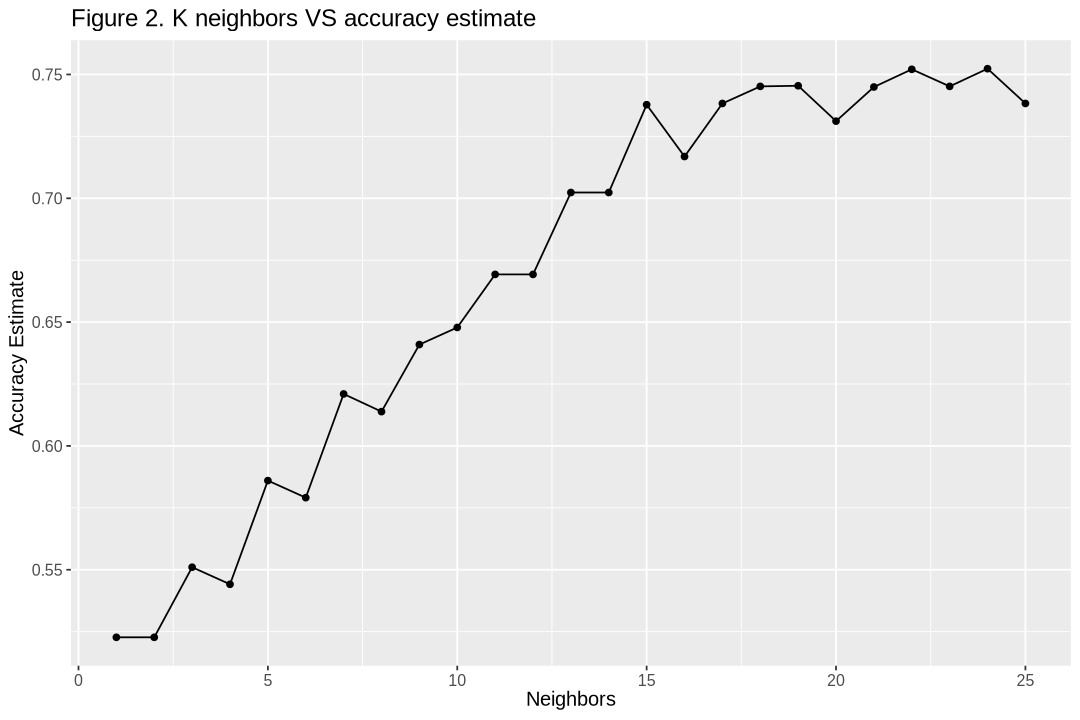

In [8]:
set.seed(111)

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", 
       y = "Accuracy Estimate",
      title = "Figure 2. K neighbors VS accuracy estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k

best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

In this case the best number of neighbors from a  was k = 24 with roughly 75% accuracy. The higher k value means that the model benefits from some generalization.

Next, we implement the best k into the workflow.

In [9]:
set.seed(111)

player_recipe <- recipe(subscribe ~ Age + played_hours, data = player_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit2 <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(knn_spec2) |>
  fit(data = player_train)

knn_fit2

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(24,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.262069
Best kernel: rectangular
Best k: 24

Now, we will look at accuracy, recall and precision of the classifier using the testing data

In [14]:
set.seed(111)

levels(player_test$subscribe)

player_test_predictions2 <- predict(knn_fit2, player_test) |>
  bind_cols(player_test)

player_test_predictions2 |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")


player_test_predictions2 |>
    precision(truth = subscribe, estimate = .pred_class, event_level="second")

player_test_predictions2 |>
    recall(truth = subscribe, estimate = .pred_class, event_level="second")

confusion <- player_test_predictions2 |>
             conf_mat(truth = subscribe, estimate = .pred_class)
confusion

[1] "FALSE" "TRUE"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7959184


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7826087


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,1


          Truth
Prediction FALSE TRUE
     FALSE     3    0
     TRUE     10   36

In [15]:
conf_tibble <- as_tibble(confusion$table)
conf_tibble



Prediction,Truth,n
<chr>,<chr>,<dbl>
FALSE,FALSE,3
TRUE,FALSE,10
FALSE,TRUE,0
TRUE,TRUE,36


- Precision of roughly 78% means that when the model predicts a player is subscribed, it is correct about 78% of the time. So, there are some false positives which are cases where the model predicts subscribed but the player is actually unsubscribed.

- Recall = 100% means the model successfully identified all actual subscribed players so it never missed a subscribed player (no false negatives). This is excellent sensitivity for detecting subscribers.

- Accuracy of roughly 79% seems reasonably high, but given the class imbalance (about 73% subscribed), this could be inflated by the model’s tendency to predict subscribed more often.

From the confusion matrix, the model misclassifies 10 unsubscribed players as subscribed (false positives), but it correctly identifies 3 unsubscribed players (true negatives).

The false positives indicate the model tends to over-predict subscription, meaning it may flag some unsubscribed players as subscribed, reducing precision.

# Plot predicted VS actual values

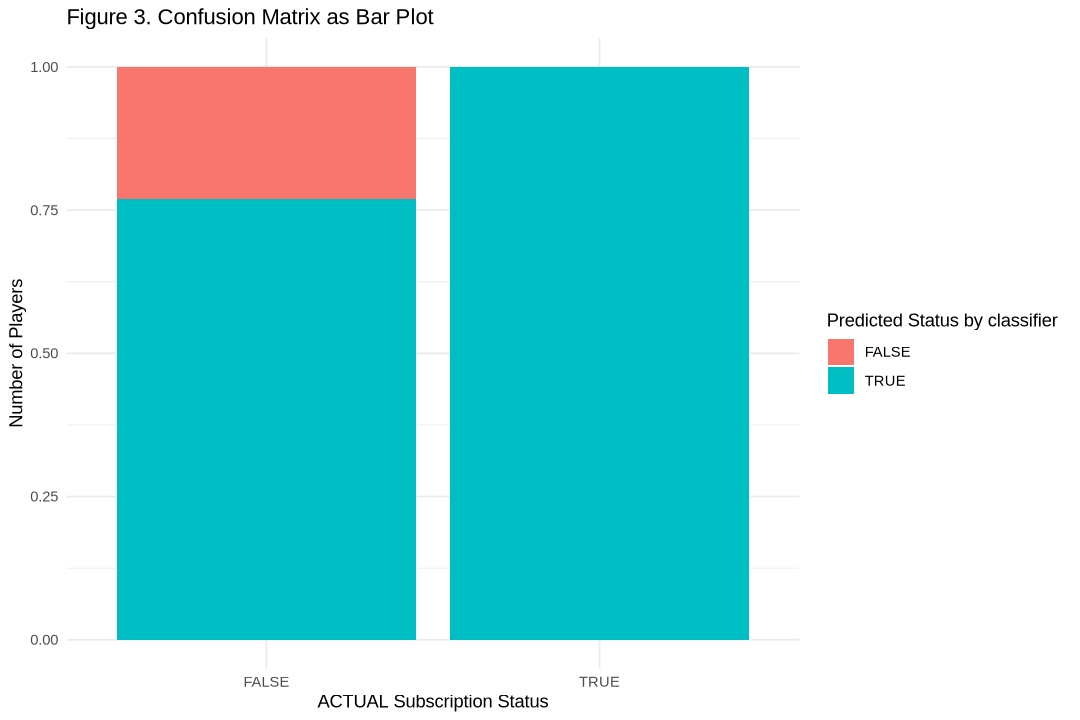

In [16]:
bar_plot <- conf_tibble |>
    ggplot(aes(x = Truth, y = n, fill = Prediction)) +
  geom_bar(stat = "identity", position = "fill") +
  labs(
    title = "Figure 3. Confusion Matrix as Bar Plot",
    x = "ACTUAL Subscription Status",
    y = "Number of Players",
    fill = "Predicted Status by classifier"
  ) +
  theme_minimal()

bar_plot

Figure 3 shows that the classifier correctly identified all subscribed users (TRUE class), achieving perfect recall for this class. For the unsubscribed users (FALSE class), the classifier correctly predicted about 75% of cases, indicating a reasonably good, but not perfect, recall for the minority class.

This result aligns with expectations given the class imbalance in the data, where approximately 75% were subscribed and 25% unsubscribed. The model tends to favor the majority subscribed class but still maintains decent performance on the minority unsubscribed class.


The classifiers performance suggests there is some predictive relationship between hours played, age, and newsletter subscription, because of the 79% accuracy suggesting that there is a pattern that the model learned. However, because of the class imbalance we cannot be sure its because of learning meaningful shapes in the data or the high ratio of the TRUE class.

In other words, while hours played and age provide useful signals to predict newsletter subscription status, the model’s imperfect performance (especially in detecting unsubscribed players) suggests that these variables alone may not fully explain subscription behavior. Further features or data could improve prediction.

Impact:

This classifiers tendancy to confidently predict subscribed users somewhat allows Frank Woods research group to use Age and Played Hours as newsletter subscription predictors. At least with some false positives (players predicted to subscribe but actually didn't) and prefect recall of the TRUE (subscribed) class they will not be missing any players that might be a good target to send newsletter subscription ads.

Improvement:

While hours played and age provide useful signals to predict newsletter subscription status, the model’s imperfect performance (especially in detecting unsubscribed players) suggests that these variables alone may not fully explain subscription behavior. To further improve recall and overall balance, applying techniques such as step_downsample() to reduce the majority class size or other sampling methods could help the model better learn the patterns in the minority class, potentially increasing the accuracy of predictions for unsubscribed players.

